Практическая работа №7. Использование автоэнкодера для решения задач семантической сегментации. Часть 1

Этап 1. Выбор и обработка исходных данных. Разделение на обучающую и тестовую выборку

In [1]:
%pip install split-folders
%pip install patchify
%pip install segmentation-models
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import cv2
import os
import pickle
import numpy as np
from pathlib import Path
from PIL import Image
from patchify import patchify
from matplotlib import pyplot as plt
import segmentation_models as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from keras.metrics import MeanIoU
import tensorflow as tf
sm.set_framework('tf.keras')

import tensorflow
tensorflow.compat.v1.enable_eager_execution()

import pandas as pd

import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "png"

In [4]:
dataset_dir = 'datasets/Semantic segmentation dataset'
patch_size = 256

In [5]:
image_dataset = []

for tile in os.listdir(dataset_dir):
    if tile.startswith('Tile'):
        for image_dir in os.listdir(f'{dataset_dir}/{tile}'):
            if image_dir == 'images':
                images = os.listdir(f'{dataset_dir}/{tile}/{image_dir}')
                for i, image_name in enumerate(images):
                    if image_name.endswith(".jpg"):
                        image = cv2.imread(f'{dataset_dir}/{tile}/{image_dir}/{image_name}', 1)
                        SIZE_X = (image.shape[1] // patch_size) * patch_size
                        SIZE_Y = (image.shape[0] // patch_size) * patch_size
                        image = Image.fromarray(image)
                        image = image.crop((0, 0, SIZE_X, SIZE_Y))
                        image = np.array(image)

                        # Разделяем изображение на части
                        print("Now patchifying image:", f'{dataset_dir}/{tile}/{image_dir}/{image_name}')
                        patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)

                        for i in range(patches_img.shape[0]):
                            for j in range(patches_img.shape[1]):

                                single_patch_img = patches_img[i, j, :, :]
                                single_patch_img = single_patch_img[0]


                                os.makedirs(f'{dataset_dir}/Image', exist_ok=True)
                                cv2.imwrite(f'{dataset_dir}/Image/{image_name}_patch_{i}{j}.jpg', single_patch_img)
                                image_dataset.append(f'{dataset_dir}/Image/{image_name}_patch_{i}{j}.jpg')

Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_001.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_002.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_003.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_004.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_005.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_006.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_007.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_008.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 1/images/image_part_009.jpg
Now patchifying image: datasets/Semantic segmentation dataset/Tile 2/images/image_part_001.jpg
Now patchifying image: datasets/Semantic segmentat

In [6]:
mask_dataset = []  
for tile in os.listdir(dataset_dir):
    if tile.startswith('Tile'):
        for mask_dir in os.listdir(f'{dataset_dir}/{tile}'):
            if mask_dir == 'masks':
                masks = os.listdir(f'{dataset_dir}/{tile}/{mask_dir}')
                for i, mask_name in enumerate(masks):
                    if mask_name.endswith(".png"):
                        mask = cv2.imread(f'{dataset_dir}/{tile}/{mask_dir}/{mask_name}', 1)
                        SIZE_X = (mask.shape[1] // patch_size) * patch_size
                        SIZE_Y = (mask.shape[0] // patch_size) * patch_size
                        mask = Image.fromarray(mask)
                        mask = mask.crop((0, 0, SIZE_X, SIZE_Y))
                        mask = np.array(mask)

                        # Разделяем маску на части
                        print("Now patchifying mask:", f'{dataset_dir}/{tile}/{mask_dir}/{mask_name}')
                        patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                        for i in range(patches_mask.shape[0]):
                            for j in range(patches_mask.shape[1]):

                                single_patch_mask = patches_mask[i, j, :, :]
                                single_patch_mask = single_patch_mask[0]
                                
                                os.makedirs(f'{dataset_dir}/Mask', exist_ok=True)
                                cv2.imwrite(f'{dataset_dir}/Mask/{mask_name}_patch_{i}{j}.png', single_patch_mask)
                                mask_dataset.append(f'{dataset_dir}/Mask/{mask_name}_patch_{i}{j}.png')

Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_001.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_002.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_003.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_004.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_005.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_006.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_007.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_008.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 1/masks/image_part_009.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 2/masks/image_part_001.png
Now patchifying mask: datasets/Semantic segmentation dataset/Tile 2/ma

In [7]:
import splitfolders

input_folder = r'datasets/Semantic segmentation dataset'
output_folder = r'datasets/data_for_training_and_testing'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None)

Copying files: 1098 files [00:00, 1936.64 files/s]


In [8]:
import shutil

src_train_img = r'datasets/data_for_training_and_testing/train/Image/'
src_train_msk = r'datasets/data_for_training_and_testing/train/Mask/'
src_val_img   = r'datasets/data_for_training_and_testing/val/Image/'
src_val_msk   = r'datasets/data_for_training_and_testing/val/Mask/'

dst_train_img = r'datasets/dataset/train_image/train'
dst_train_msk = r'datasets/dataset/train_mask/train'
dst_val_img   = r'datasets/dataset/val_image/val'
dst_val_msk   = r'datasets/dataset/val_mask/val'

shutil.copytree(src_train_img, dst_train_img)
shutil.copytree(src_train_msk, dst_train_msk)
shutil.copytree(src_val_img, dst_val_img)
shutil.copytree(src_val_msk, dst_val_msk)

'datasets/dataset/val_mask/val'

In [9]:
train_img_dir = 'datasets/dataset/train_image/train'
train_mask_dir = 'datasets/dataset/train_mask/train'

img_list = sorted(os.listdir(train_img_dir))
msk_list = sorted(os.listdir(train_mask_dir))

num_images = len(os.listdir(train_img_dir))

<Figure size 1200x800 with 0 Axes>

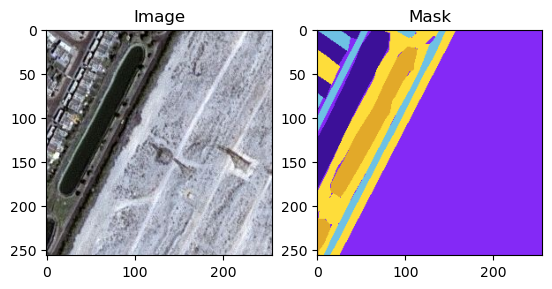

<Figure size 1200x800 with 0 Axes>

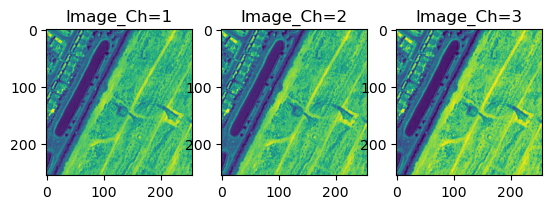

<Figure size 1200x800 with 0 Axes>

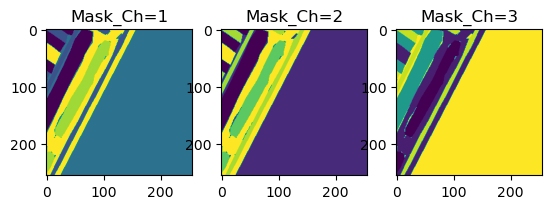

In [10]:
import random
from matplotlib import pyplot as plt

img_num = random.randint(0, num_images-1)

img_for_plot = cv2.imread(os.path.join(train_img_dir, img_list[img_num]))
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

mask_for_plot =cv2.imread(os.path.join(train_mask_dir, msk_list[img_num]))
mask_for_plot = cv2.cvtColor(mask_for_plot, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 2)

axis[0].imshow(img_for_plot, cmap=plt.get_cmap('gray'),vmin=0,vmax=100)
axis[0].set_title('Image')

axis[1].imshow(mask_for_plot)
axis[1].set_title('Mask')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(img_for_plot[:,:,0])
axis[0].set_title('Image_Ch=1')

axis[1].imshow(img_for_plot[:,:,1])
axis[1].set_title('Image_Ch=2')

axis[2].imshow(img_for_plot[:,:,2])
axis[2].set_title('Image_Ch=3')

plt.show()

fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
 
figure, axis = plt.subplots(1, 3)

axis[0].imshow(mask_for_plot[:,:,0])
axis[0].set_title("Mask_Ch=1")

axis[1].imshow(mask_for_plot[:,:,1])
axis[1].set_title("Mask_Ch=2")

axis[2].imshow(mask_for_plot[:,:,2])
axis[2].set_title("Mask_Ch=3")

plt.show()

Этап 2. Предобработка обучающей и валидационной выборки. Разработка архитектуры модели

In [11]:
Building = np.array((60, 16, 152))
Land = np.array((132, 41, 246))
Road = np.array((110, 193, 228))
Vegetation = np.array((254, 221, 58))
Water = np.array((226, 169, 41))
Unlabeled = np.array((155, 155, 155))

In [12]:
def rgb_to_2D_label(label):
    """
    Преобразовать массив пикселей маски в массив из номеров классов
    """
    if len(label.shape) == 3: 
        label = label[:,:,:3]
    if len(label.shape) == 4: 
        label = label[:,:,:,:3]

    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg[np.all(label == Building,axis=-1)] = 0
    label_seg[np.all(label==Land,axis=-1)] = 1
    label_seg[np.all(label==Road,axis=-1)] = 2
    label_seg[np.all(label==Vegetation,axis=-1)] = 3
    label_seg[np.all(label==Water,axis=-1)] = 4
    label_seg[np.all(label==Unlabeled,axis=-1)] = 5

    if len(label.shape) == 3: 
        label_seg = label_seg[:,:,0]
    if len(label.shape) == 4: 
        label_seg = label_seg[:,:,:,0]
        
    return label_seg

In [13]:
scaler = MinMaxScaler()

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

def preprocess_data(img, mask, num_class):
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img) 
    mask = rgb_to_2D_label(mask)
    mask = to_categorical(mask, num_class)
      
    return (img, mask)

In [14]:
seed=24
batch_size= 16
n_classes=6

In [15]:
from keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [16]:
train_img_path = r'datasets/dataset/train_image'
train_mask_path = r'datasets/dataset/train_mask'
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=6)

val_img_path = r'datasets/dataset/val_image'
val_mask_path = r'datasets/dataset/val_mask'
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=6)

In [17]:
num_train_imgs = len(os.listdir(r'datasets/dataset/train_image/train'))
num_val_images = len(os.listdir(r'datasets/dataset/val_image/val'))

steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

print(steps_per_epoch, val_steps_per_epoch)

25 8


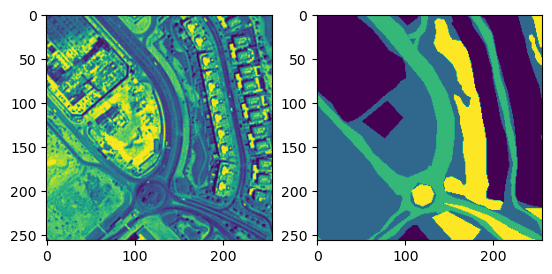

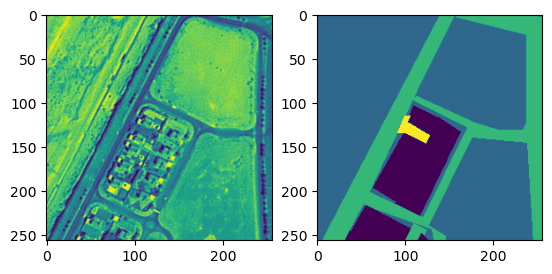

Unique labels in label dataset are:  [0 1 2 3]


In [19]:
x, y = train_img_gen.__next__()

for i in range(0,1):
    image = x[i][:,:,0]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

x_val, y_val = val_img_gen.__next__()

for i in range(0,1):
    image = x_val[i][:,:,0]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

labels, count = np.unique(mask, return_counts=True) #Check for each channel. All chanels are identical

print("Unique labels in label dataset are: ", np.unique(labels))

Этап 3. Обучение модели

In [20]:
# categorical focal loss
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_1 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_1.compile(optimizer='adam', loss=sm.losses.categorical_focal_loss, metrics=metrics)
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['bn_data[0][0]']                
                                3)                                                          

In [20]:
history_1 = model_1.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
)                      

Epoch 1/50
25/25 [==============================] - 17s 286ms/step - loss: 0.0295 - accuracy: 0.5839 - iou_score: 0.1501 - f1-score: 0.2358 - val_loss: 0.3409 - val_accuracy: 0.2309 - val_iou_score: 0.0585 - val_f1-score: 0.1030
Epoch 2/50
25/25 [==============================] - 6s 252ms/step - loss: 0.0157 - accuracy: 0.7727 - iou_score: 0.2278 - f1-score: 0.3414 - val_loss: 0.0618 - val_accuracy: 0.1217 - val_iou_score: 0.0680 - val_f1-score: 0.1239
Epoch 3/50
25/25 [==============================] - 6s 255ms/step - loss: 0.0124 - accuracy: 0.8075 - iou_score: 0.2810 - f1-score: 0.4083 - val_loss: 0.0507 - val_accuracy: 0.3479 - val_iou_score: 0.0840 - val_f1-score: 0.1459
Epoch 4/50
25/25 [==============================] - 6s 249ms/step - loss: 0.0115 - accuracy: 0.8102 - iou_score: 0.3017 - f1-score: 0.4313 - val_loss: 0.0414 - val_accuracy: 0.3643 - val_iou_score: 0.0841 - val_f1-score: 0.1478
Epoch 5/50
25/25 [==============================] - 6s 247ms/step - loss: 0.0108 - accu

In [21]:
model_1.save('models/unet_categorical_focal_loss.h5')

In [22]:
# categorical_crossentropy
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_2 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_2.compile(optimizer='adam', loss=sm.losses.categorical_crossentropy, metrics=metrics)
model_2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [23]:
history_2 = model_2.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
)

Epoch 1/50
25/25 [==============================] - 9s 272ms/step - loss: 0.1789 - accuracy: 0.6473 - iou_score: 0.1836 - f1-score: 0.2760 - val_loss: 1.2677 - val_accuracy: 0.5166 - val_iou_score: 0.0878 - val_f1-score: 0.1164
Epoch 2/50
25/25 [==============================] - 6s 255ms/step - loss: 0.1131 - accuracy: 0.7670 - iou_score: 0.2930 - f1-score: 0.4123 - val_loss: 1.2929 - val_accuracy: 0.5155 - val_iou_score: 0.0869 - val_f1-score: 0.1135
Epoch 3/50
25/25 [==============================] - 6s 252ms/step - loss: 0.0969 - accuracy: 0.8088 - iou_score: 0.3537 - f1-score: 0.4820 - val_loss: 0.3636 - val_accuracy: 0.5369 - val_iou_score: 0.0958 - val_f1-score: 0.1320
Epoch 4/50
25/25 [==============================] - 6s 249ms/step - loss: 0.0871 - accuracy: 0.8260 - iou_score: 0.4051 - f1-score: 0.5336 - val_loss: 0.2673 - val_accuracy: 0.5057 - val_iou_score: 0.0924 - val_f1-score: 0.1489
Epoch 5/50
25/25 [==============================] - 6s 254ms/step - loss: 0.0834 - accur

In [24]:
model_2.save('models/unet_categorical_crossentropy.h5')

In [25]:
# categorical_focal_dice_loss
metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_3 = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

model_3.compile(optimizer='adam', loss=sm.losses.categorical_focal_dice_loss, metrics=metrics)
model_3.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_68 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [31]:
history_3 = model_3.fit(
    train_img_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=val_img_gen,
    validation_steps=val_steps_per_epoch,
)

Epoch 1/50
25/25 [==============================] - 6s 244ms/step - loss: 0.3716 - accuracy: 0.8258 - iou_score: 0.5481 - f1-score: 0.6585 - val_loss: 0.9770 - val_accuracy: 0.3755 - val_iou_score: 0.0788 - val_f1-score: 0.1244
Epoch 2/50
25/25 [==============================] - 6s 248ms/step - loss: 0.3789 - accuracy: 0.8287 - iou_score: 0.5383 - f1-score: 0.6512 - val_loss: 0.9283 - val_accuracy: 0.5224 - val_iou_score: 0.0867 - val_f1-score: 0.1366
Epoch 3/50
25/25 [==============================] - 6s 245ms/step - loss: 0.3522 - accuracy: 0.8526 - iou_score: 0.5699 - f1-score: 0.6725 - val_loss: 1.0206 - val_accuracy: 0.5222 - val_iou_score: 0.0872 - val_f1-score: 0.1149
Epoch 4/50
25/25 [==============================] - 6s 249ms/step - loss: 0.3415 - accuracy: 0.8492 - iou_score: 0.5792 - f1-score: 0.6829 - val_loss: 1.0323 - val_accuracy: 0.5342 - val_iou_score: 0.0895 - val_f1-score: 0.1153
Epoch 5/50
25/25 [==============================] - 6s 249ms/step - loss: 0.3404 - accur

In [32]:
model_3.save('models/unet_categorical_focal_dice_loss.h5')

Этап 4. Визуализация процесса обучения. Оценка точности

In [33]:
def display_training(history, name):
    fig, axs = plt.subplots(4, 1, sharex=True)
    
    fig.set_figwidth(15)
    fig.set_figheight(15)
    fig.suptitle(name)
    plt.xlabel('Epochs', fontsize=10)
    
    axs[0].set_title("Training and validation loss")
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_ylabel('Loss')
    axs[0].legend(['Training loss', 'Validation loss'], loc="upper right")

    axs[1].set_title("Training and validation accuracy")
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_ylabel('Accuracy')
    axs[1].legend(['Training accuracy', 'Validation accuracy'], loc="lower right")

    axs[2].set_title("Training and validation IOU score")
    axs[2].plot(history.history['iou_score'])
    axs[2].plot(history.history['val_iou_score'])
    axs[2].set_ylabel('IOU score')
    axs[2].legend(['Training IOU score', 'Validation IOU score'], loc="lower right")

    axs[3].set_title("Training and validation F1 score")
    axs[3].plot(history.history['f1-score'])
    axs[3].plot(history.history['val_f1-score'])
    axs[3].set_ylabel('F1 score')
    _  = axs[3].legend(['Training F1 score', 'Validation F1 score'], loc="lower right")

    fig.subplots_adjust(bottom=0.1, top=0.95)

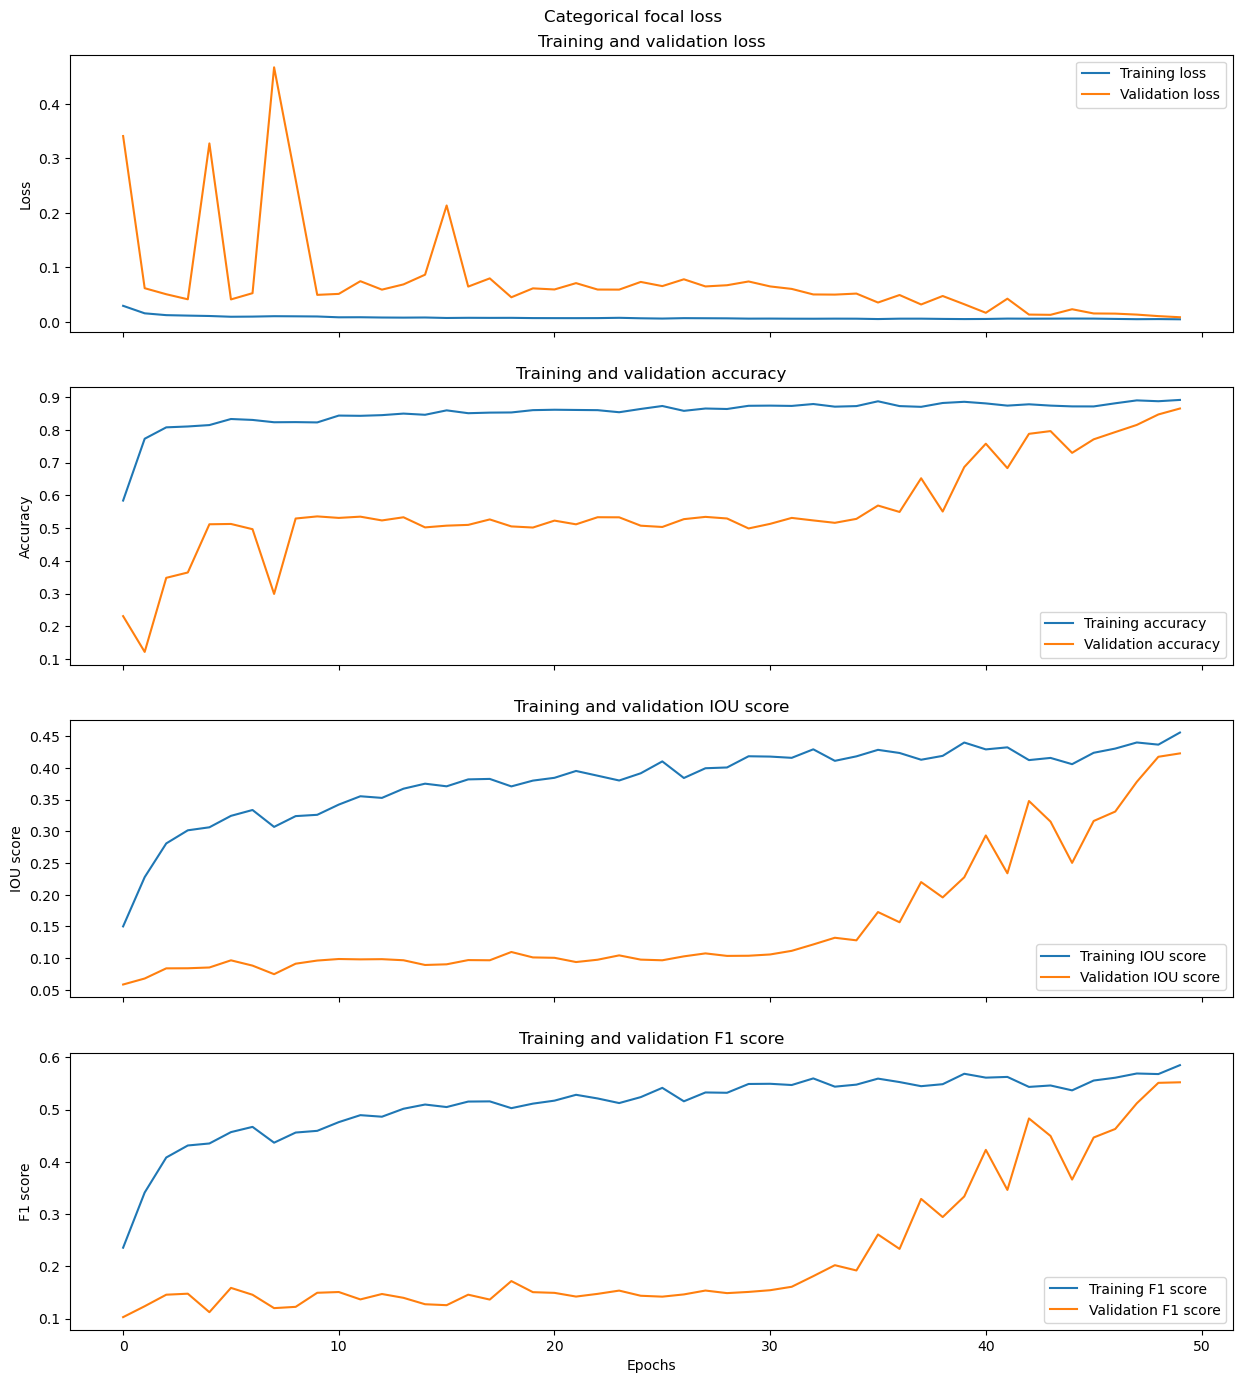

In [34]:
display_training(history_1, "Categorical focal loss")

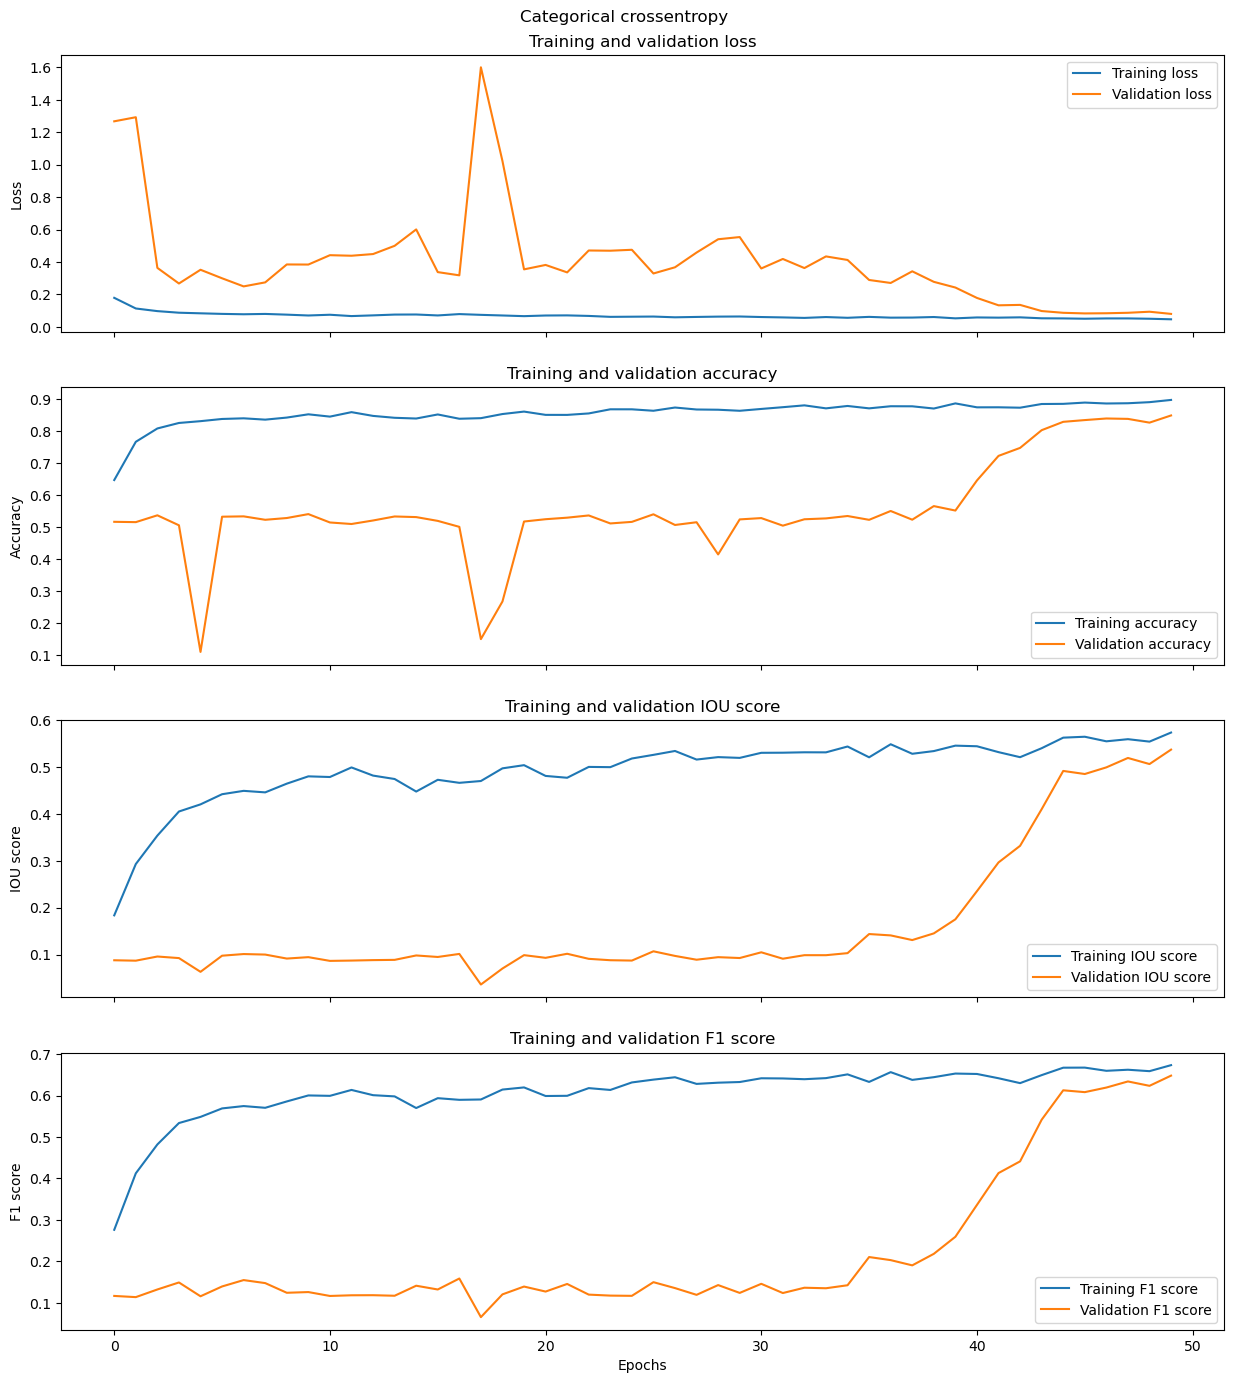

In [35]:
display_training(history_2, "Categorical crossentropy")

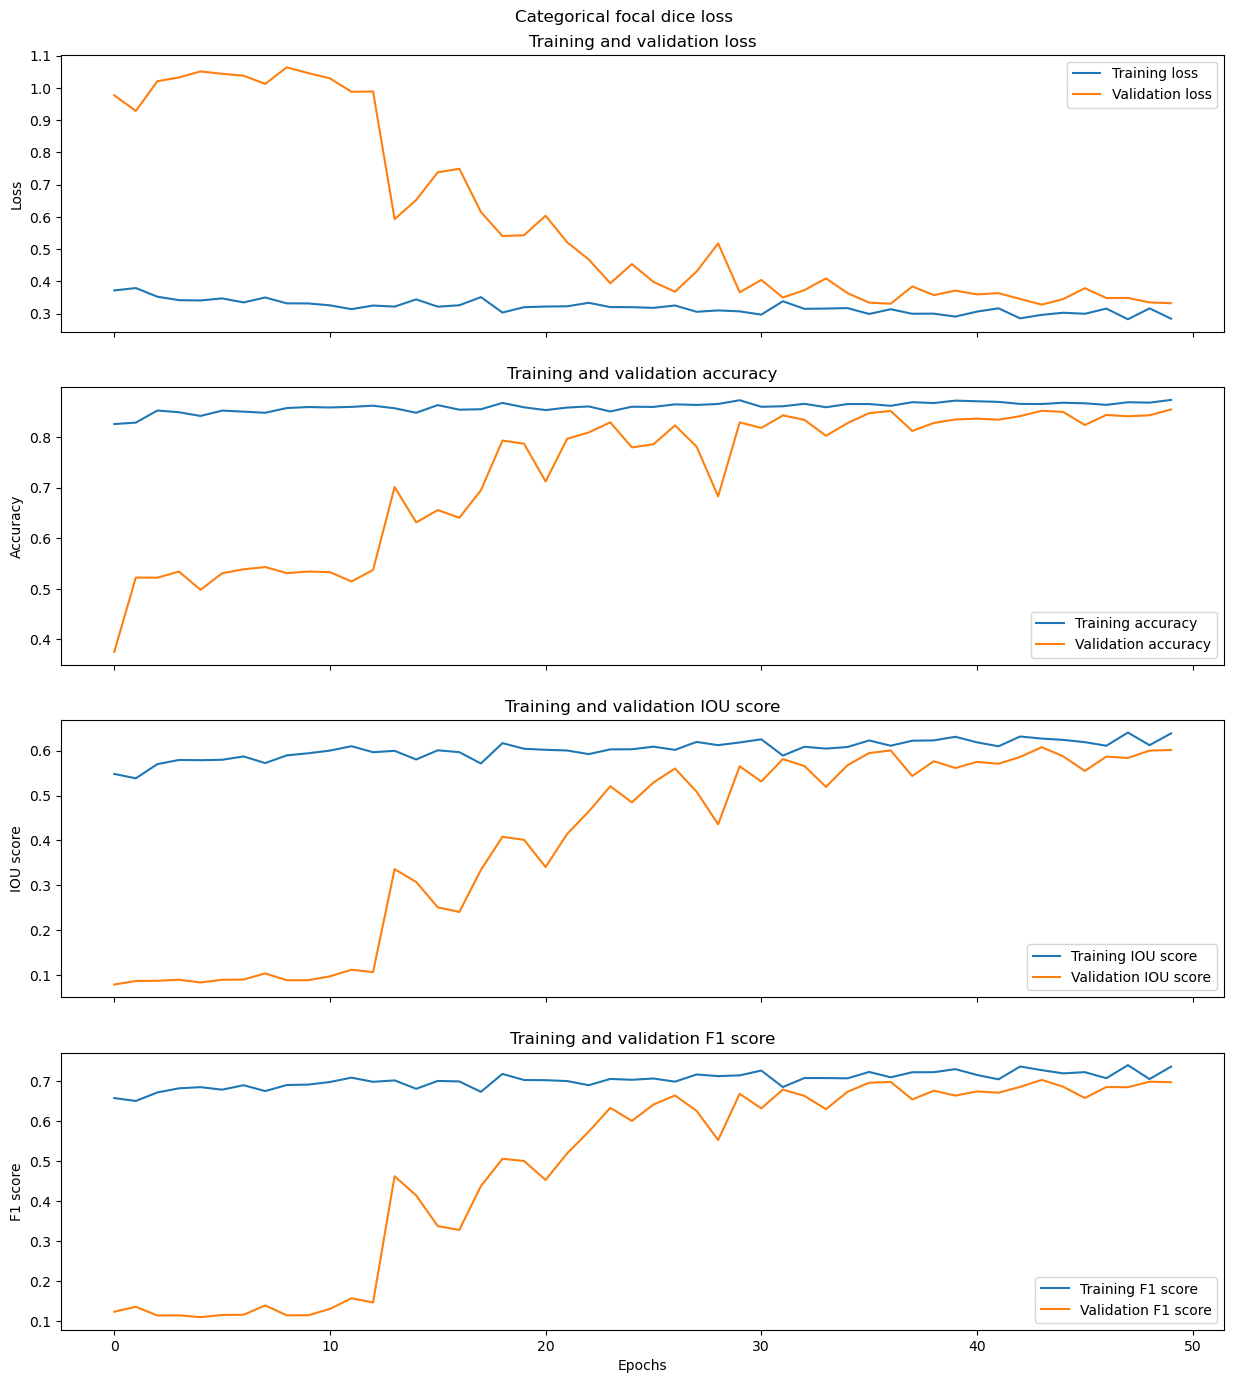

In [36]:
display_training(history_3, "Categorical focal dice loss")

In [37]:
from keras.models import load_model

metrics = ['accuracy', sm.metrics.iou_score, sm.metrics.FScore()]
model_1_1 = load_model('models/unet_categorical_crossentropy.h5', compile=False)
model_1_1.compile(metrics=metrics)
test_pred_model_1 = model_1_1.evaluate(val_img_gen, steps=num_val_images)

model_2_2 = load_model('models/unet_categorical_focal_loss.h5', compile=False)
model_2_2.compile(metrics=metrics)
test_pred_model_2 = model_2_2.evaluate(val_img_gen, steps=num_val_images)

model_3_3 = load_model('models/unet_categorical_focal_dice_loss.h5', compile=False)
model_3_3.compile(metrics=metrics)
test_pred_model_3 = model_3_3.evaluate(val_img_gen, steps=num_val_images)

138/138 [==============================] - 25s 178ms/step - loss: 0.0000e+00 - accuracy: 0.8522 - iou_score: 0.6068 - f1-score: 0.7015


In [38]:
def print_model_evaluation(model_name, pred):
    print(f'Evaluation of {model_name}')
    print(F"Mean Accuracy = {pred[1]}") 
    print(F"Mean IOU = {pred[2]}") 
    print(F"Mean FScore = {pred[3]}") 
    print()


print_model_evaluation('Сategorical Focal Jaccard Loss', test_pred_model_1)
print_model_evaluation('Categorical Cross Entropy Loss', test_pred_model_2)
print_model_evaluation('Categorical Focal Dice Loss', test_pred_model_3)

Evaluation of Сategorical Focal Jaccard Loss
Mean Accuracy = 0.8523674011230469
Mean IOU = 0.5327579975128174
Mean FScore = 0.644180417060852

Evaluation of Categorical Cross Entropy Loss
Mean Accuracy = 0.8589295744895935
Mean IOU = 0.41610094904899597
Mean FScore = 0.5463466048240662

Evaluation of Categorical Focal Dice Loss
Mean Accuracy = 0.8521649837493896
Mean IOU = 0.6067785024642944
Mean FScore = 0.7015298008918762



In [39]:
test_image_batch, test_mask_batch = val_img_gen.__next__()
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3) 

test_pred_batch_model_1 = model_1_1.predict(test_image_batch)
test_pred_batch_model_2 = model_2_2.predict(test_image_batch)
test_pred_batch_model_3 = model_3_3.predict(test_image_batch)

test_pred_batch_model_1_argmax = np.argmax(test_pred_batch_model_1, axis=3)
test_pred_batch_model_2_argmax = np.argmax(test_pred_batch_model_2, axis=3)
test_pred_batch_model_3_argmax = np.argmax(test_pred_batch_model_3, axis=3)

1/1 [==============================] - 0s 342ms/step


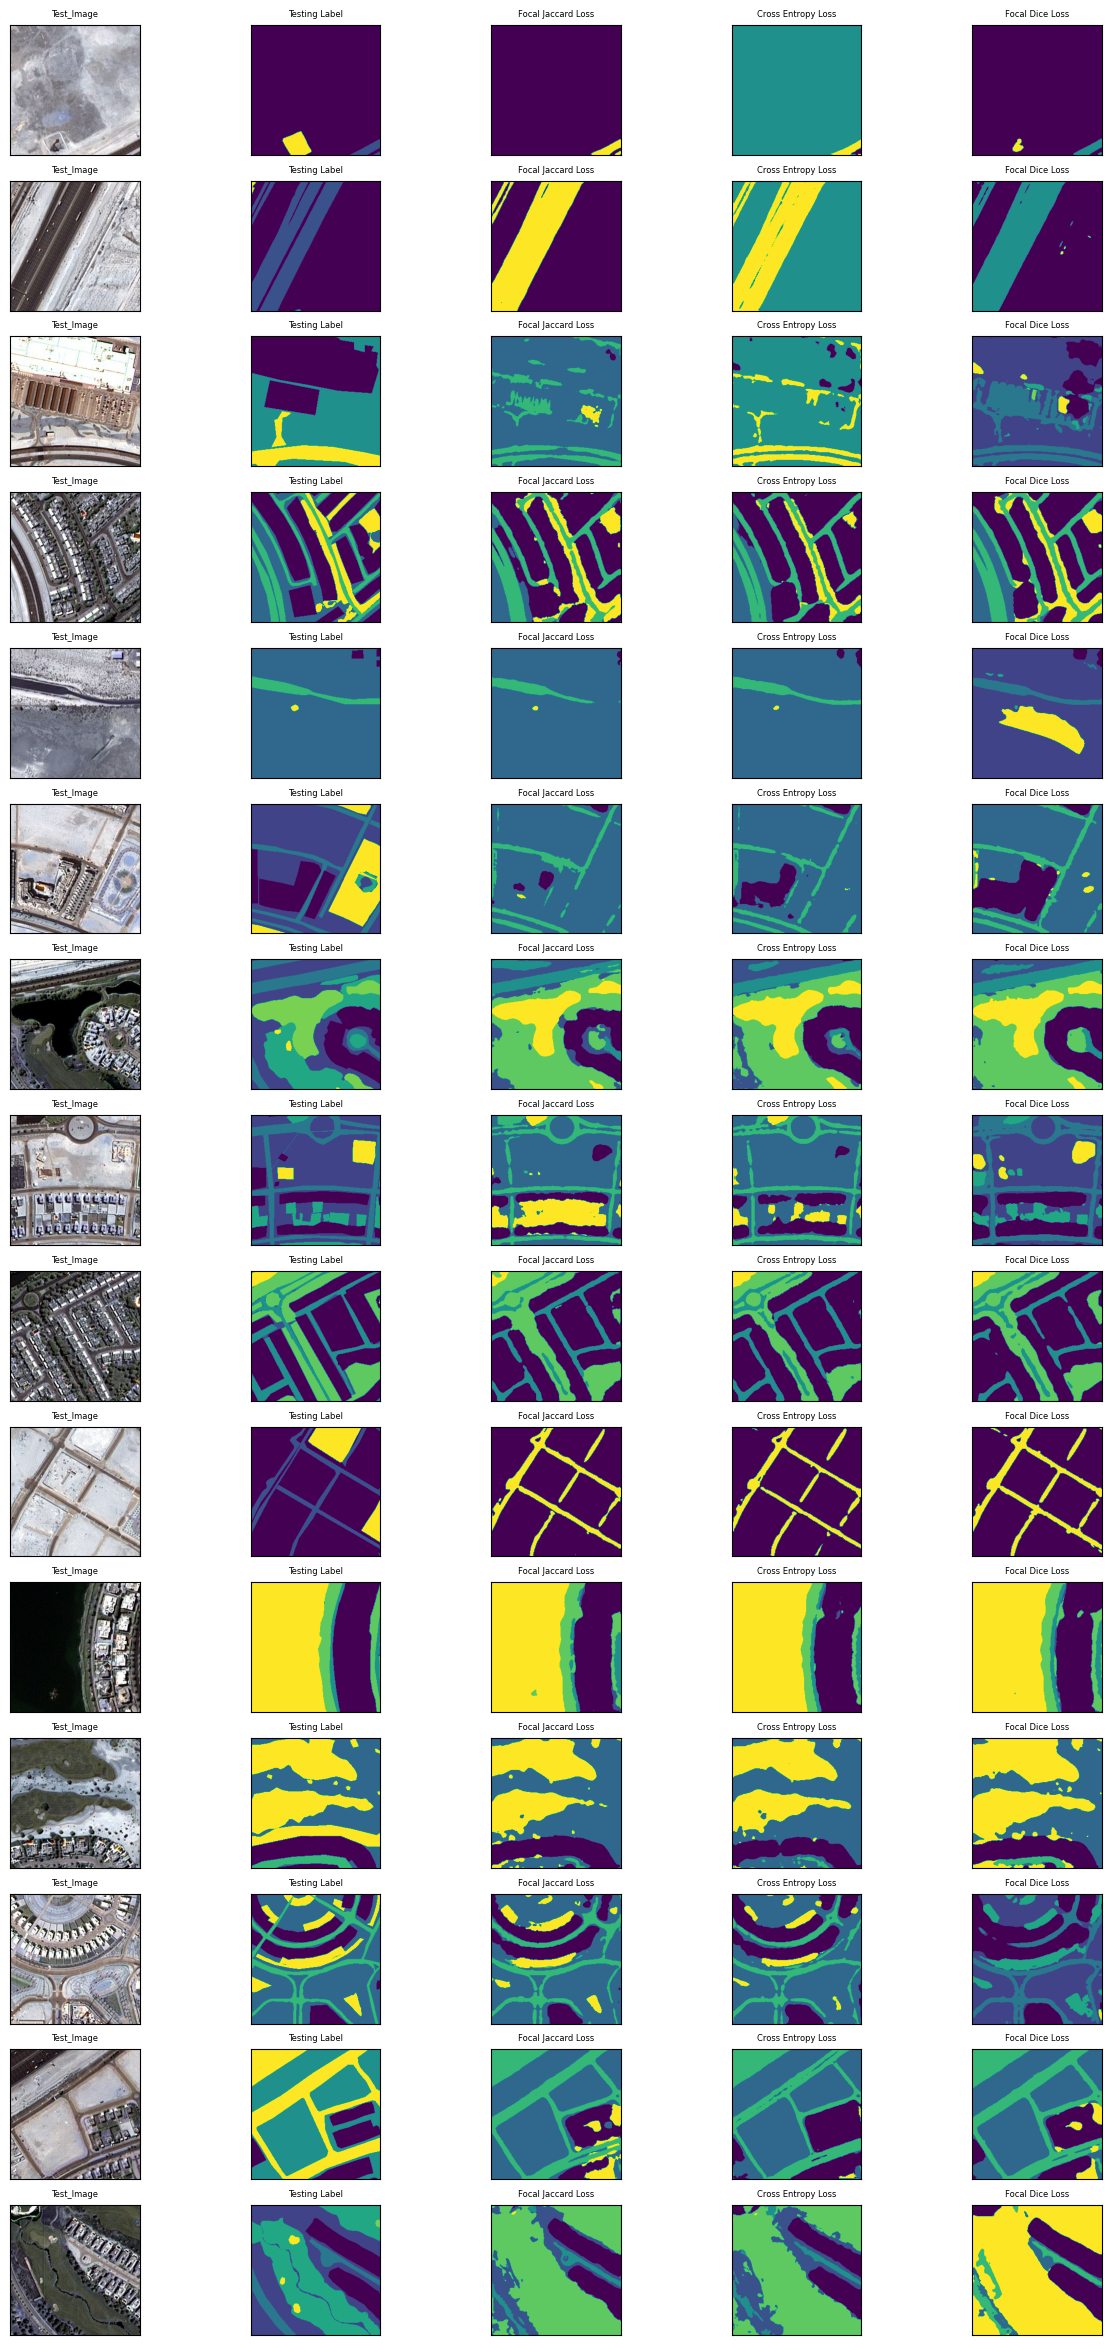

In [40]:
fig, axis = plt.subplots(test_image_batch.shape[0]-1, 5)
fig.set_figwidth(15)
fig.set_figheight(30)

for img_num in range(test_image_batch.shape[0]-1):   
    
    axis[img_num][0].imshow(test_image_batch[img_num])
    axis[img_num][0].set_title('Test_Image', fontsize = 6)
    axis[img_num][0].axes.xaxis.set_visible(False)
    axis[img_num][0].axes.yaxis.set_visible(False)


    axis[img_num][1].imshow(test_mask_batch_argmax[img_num])
    axis[img_num][1].set_title("Testing Label", fontsize = 6)
    axis[img_num][1].axes.xaxis.set_visible(False)
    axis[img_num][1].axes.yaxis.set_visible(False)

    axis[img_num][2].imshow(test_pred_batch_model_1_argmax[img_num])
    axis[img_num][2].set_title("Focal Jaccard Loss", fontsize = 6)
    axis[img_num][2].axes.xaxis.set_visible(False)
    axis[img_num][2].axes.yaxis.set_visible(False)

    axis[img_num][3].imshow(test_pred_batch_model_2_argmax[img_num])
    axis[img_num][3].set_title("Cross Entropy Loss", fontsize = 6)
    axis[img_num][3].axes.xaxis.set_visible(False)
    axis[img_num][3].axes.yaxis.set_visible(False)

    axis[img_num][4].imshow(test_pred_batch_model_3_argmax[img_num])
    axis[img_num][4].set_title("Focal Dice Loss", fontsize = 6)
    axis[img_num][4].axes.xaxis.set_visible(False)
    axis[img_num][4].axes.yaxis.set_visible(False)
    
plt.show()